In [13]:
from importlib import reload
import LRR
reload(LRR)
from LRR import *

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
799,16507.070267,16229,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,0,0
800,16175.957604,19095,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0
801,15731.132897,20484,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0
802,15118.893228,25979,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0


,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,0.139660,0.158716,0,10,44,3,0.5,0.340909,1.0,1,1,1
1,0.143329,0.176952,0,10,44,3,0.5,0.340909,1.0,1,1,0
2,0.122027,0.257976,0,10,44,3,0.5,0.340909,1.0,1,1,0
3,0.123928,0.320744,0,10,44,3,0.5,0.340909,1.0,1,0,0
4,0.123964,0.390375,0,10,44,3,0.5,0.340909,1.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.126667,0.318489,5,21,21,3,0.5,0.318182,1.0,1,0,0
800,0.121337,0.375671,5,21,21,3,0.5,0.318182,1.0,1,1,0
801,0.114176,0.403384,5,21,21,3,0.5,0.318182,1.0,1,1,0
802,0.104319,0.513018,5,21,21,3,0.5,0.318182,1.0,1,1,0


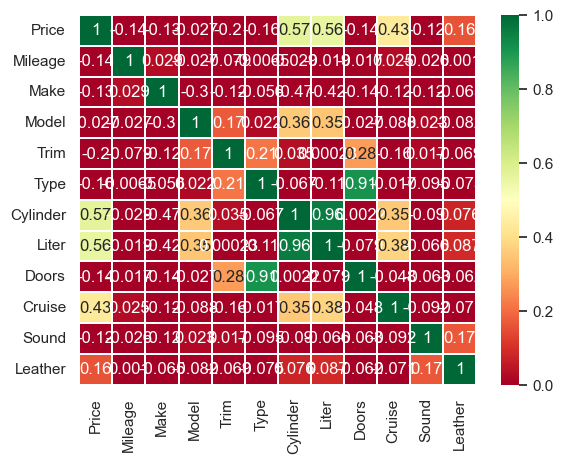

In [14]:
# Read dataframe
data = pd.read_excel('kuiper.xls')
data.dropna(inplace=True)
display(data)

# Normalization
data = norm_data(data)
display(data)

# Correlation
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

# Dependent variable
explore_column = 'Price' 

### Строим базовую модель

In [15]:
base_research = LinearRegressionResearch(data, column=explore_column, influence_measures_filename='influence_measures')
base_research.info()
base_research.run_tests()
new_model, selected_features = base_research.stepwise_selection(criteria='AIC')

                                    Price                                     
Dep. Variable:                  Price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     72.33
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          1.10e-111
Time:                        17:23:49   Log-Likelihood:                 616.99
No. Observations:                 804   AIC:                            -1210.
Df Residuals:                     792   BIC:                            -1154.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1893      0.026      7.289      0.0

,df,sum_sq,mean_sq,F,PR(>F)
Mileage,1.0,0.416122,0.416122,32.487745,1.692226e-08
Make,1.0,0.331087,0.331087,25.848898,4.611067e-07
Model,1.0,0.103290,0.103290,8.064157,4.630651e-03
Trim,1.0,1.014100,1.014100,79.173512,3.816094e-18
Type,1.0,0.331279,0.331279,25.863839,4.576635e-07
Cylinder,1.0,7.074997,7.074997,552.364222,4.438811e-93
Liter,1.0,0.001099,0.001099,0.085776,7.696937e-01
Doors,1.0,0.058861,0.058861,4.595432,3.236117e-02
Cruise,1.0,0.566785,0.566785,44.250461,5.386746e-11
Sound,1.0,0.033067,0.033067,2.581637,1.085084e-01


,dfb_Intercept,dfb_Mileage,dfb_Make,dfb_Model,dfb_Trim,dfb_Type,dfb_Cylinder,dfb_Liter,dfb_Doors,dfb_Cruise,dfb_Sound,dfb_Leather,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.039337,0.051740,0.064289,0.047192,-0.048393,-0.036718,-0.056960,0.061735,0.039385,-0.024177,-0.022214,-0.020519,0.001647,-1.145798,0.014830,-0.140581,-1.146025,-0.140609
1,-0.042182,0.029312,0.042778,0.039021,-0.027057,-0.024511,-0.036543,0.036181,0.026970,-0.006128,-0.023651,0.046676,0.000801,-0.717436,0.018334,-0.098046,-0.717216,-0.098016
2,-0.041605,0.018520,0.047740,0.043575,-0.031161,-0.027370,-0.041240,0.040721,0.030167,-0.006561,-0.026771,0.052140,0.000936,-0.800836,0.017220,-0.106007,-0.800655,-0.105983
3,-0.063242,0.010280,0.065834,0.044386,-0.036372,-0.022866,-0.035336,0.038650,0.028579,-0.005459,0.041233,0.046330,0.001189,-0.887785,0.017777,-0.119436,-0.887666,-0.119420
4,-0.046058,-0.003831,0.082622,0.043105,-0.054744,-0.027696,-0.045883,0.055524,0.034019,-0.021446,0.069480,-0.035875,0.001840,-1.168870,0.015903,-0.148587,-1.169140,-0.148622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.015629,0.024067,-0.141273,-0.059323,0.035200,0.012276,-0.112971,0.102247,-0.021806,-0.032284,0.027019,0.059321,0.003885,-1.475494,0.020967,-0.215929,-1.476593,-0.216090
800,0.050656,0.002022,-0.139582,-0.045170,0.030504,-0.000223,-0.112871,0.097840,-0.011555,-0.029643,-0.079090,0.067459,0.003305,-1.264057,0.024223,-0.199160,-1.264535,-0.199235
801,0.054790,-0.005792,-0.142638,-0.046140,0.030634,-0.000241,-0.115607,0.100183,-0.011766,-0.030140,-0.081038,0.068974,0.003454,-1.291720,0.024240,-0.203592,-1.292266,-0.203678
802,0.063909,-0.035312,-0.136540,-0.044095,0.027288,-0.000278,-0.111670,0.096659,-0.011103,-0.028277,-0.078394,0.066170,0.003268,-1.236356,0.025015,-0.198036,-1.236769,-0.198102


,student_resid,unadj_p,bonferroni(p)
0,-1.146025,0.252131,1.0
1,-0.717216,0.473453,1.0
2,-0.800655,0.423572,1.0
3,-0.887666,0.374990,1.0
4,-1.169140,0.242699,1.0
...,...,...,...
799,-1.476593,0.140183,1.0
800,-1.264535,0.206411,1.0
801,-1.292266,0.196642,1.0
802,-1.236769,0.216540,1.0


Breusch-Pagan test: 
LM statistic: 204.89798602694415      LM-Test p-value: 7.156551302075629e-38 
F-statistic: 24.624612586602776       F-Test p-value: 5.444928919228778e-44


,Variable,VIF,Tolerance
0,Mileage,5.764415,0.173478
1,Make,4.480187,0.223205
2,Model,4.913666,0.203514
3,Trim,4.743612,0.210810
4,Type,42.586401,0.023482
5,Cylinder,27.738852,0.036051
6,Liter,37.594367,0.026600
7,Doors,30.978091,0.032281
8,Cruise,4.740424,0.210952
9,Sound,3.132204,0.319264


                                STEPS AIC                              
Selected Features: ['Mileage', 'Make', 'Model', 'Trim', 'Type', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather'] 
AIC: -1209.9803269004008 
Selected Features: ['Mileage', 'Make', 'Model', 'Trim', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather'] 
AIC: -1211.8336577695748 
Selected Features: ['Mileage', 'Make', 'Model', 'Trim', 'Cylinder', 'Doors', 'Cruise', 'Sound', 'Leather'] 
AIC: -1212.5075915952377 


### Проведём исследование улучшенной модели

                                    Price                                     
Dep. Variable:                  Price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     88.30
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          2.54e-113
Time:                        17:23:52   Log-Likelihood:                 616.25
No. Observations:                 804   AIC:                            -1213.
Df Residuals:                     794   BIC:                            -1166.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1826      0.025      7.212      0.0

,df,sum_sq,mean_sq,F,PR(>F)
Mileage,1.0,0.416122,0.416122,32.510179,1.672152e-08
Make,1.0,0.331087,0.331087,25.866748,4.567454e-07
Model,1.0,0.103290,0.103290,8.069726,4.616294e-03
Trim,1.0,1.014100,1.014100,79.228185,3.704554e-18
Cylinder,1.0,7.313733,7.313733,571.397263,1.483215e-95
Doors,1.0,0.141969,0.141969,11.091574,9.072480e-04
Cruise,1.0,0.562785,0.562785,43.968471,6.165072e-11
Sound,1.0,0.035819,0.035819,2.798412,9.475167e-02
Leather,1.0,0.252981,0.252981,19.764569,1.000577e-05
Residual,794.0,10.162989,0.012800,NaN,NaN


,dfb_Intercept,dfb_Mileage,dfb_Make,dfb_Model,dfb_Trim,dfb_Cylinder,dfb_Doors,dfb_Cruise,dfb_Sound,dfb_Leather,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.033114,0.051047,0.064297,0.040815,-0.044315,0.008204,0.001188,-0.021150,-0.013695,-0.017950,0.001413,-1.101232,0.011517,-0.118867,-1.101380,-0.118883
1,-0.038097,0.028492,0.041605,0.033892,-0.024066,-0.003538,0.003600,-0.004950,-0.017777,0.045082,0.000714,-0.678829,0.015253,-0.084483,-0.678598,-0.084454
2,-0.037349,0.018487,0.046702,0.038060,-0.027920,-0.004367,0.004091,-0.005237,-0.020275,0.050631,0.000829,-0.761637,0.014098,-0.091076,-0.761435,-0.091052
3,-0.058657,0.010731,0.065065,0.040310,-0.033589,0.006036,0.010595,-0.003736,0.044743,0.045603,0.001153,-0.852226,0.015624,-0.107367,-0.852079,-0.107348
4,-0.039592,-0.002416,0.082880,0.038919,-0.051344,0.021612,0.009331,-0.017887,0.074056,-0.032824,0.001736,-1.127059,0.013482,-0.131758,-1.127251,-0.131781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.035283,0.025054,-0.121830,-0.048523,0.030353,-0.054437,-0.049747,-0.014610,0.031957,0.060944,0.003076,-1.386253,0.015757,-0.175399,-1.387059,-0.175501
800,0.065227,0.004182,-0.120414,-0.037705,0.026719,-0.061950,-0.050193,-0.014559,-0.066564,0.066951,0.002530,-1.170539,0.018132,-0.159067,-1.170812,-0.159104
801,0.069654,-0.002981,-0.123212,-0.038561,0.026842,-0.063618,-0.051341,-0.014731,-0.068308,0.068561,0.002649,-1.197940,0.018125,-0.162761,-1.198269,-0.162806
802,0.077348,-0.030237,-0.117392,-0.036662,0.023699,-0.061474,-0.048845,-0.013407,-0.065824,0.065530,0.002500,-1.141962,0.018807,-0.158101,-1.142181,-0.158131


,student_resid,unadj_p,bonferroni(p)
0,-1.101380,0.271066,1.0
1,-0.678598,0.497591,1.0
2,-0.761435,0.446624,1.0
3,-0.852079,0.394428,1.0
4,-1.127251,0.259977,1.0
...,...,...,...
799,-1.387059,0.165813,1.0
800,-1.170812,0.242026,1.0
801,-1.198269,0.231170,1.0
802,-1.142181,0.253723,1.0


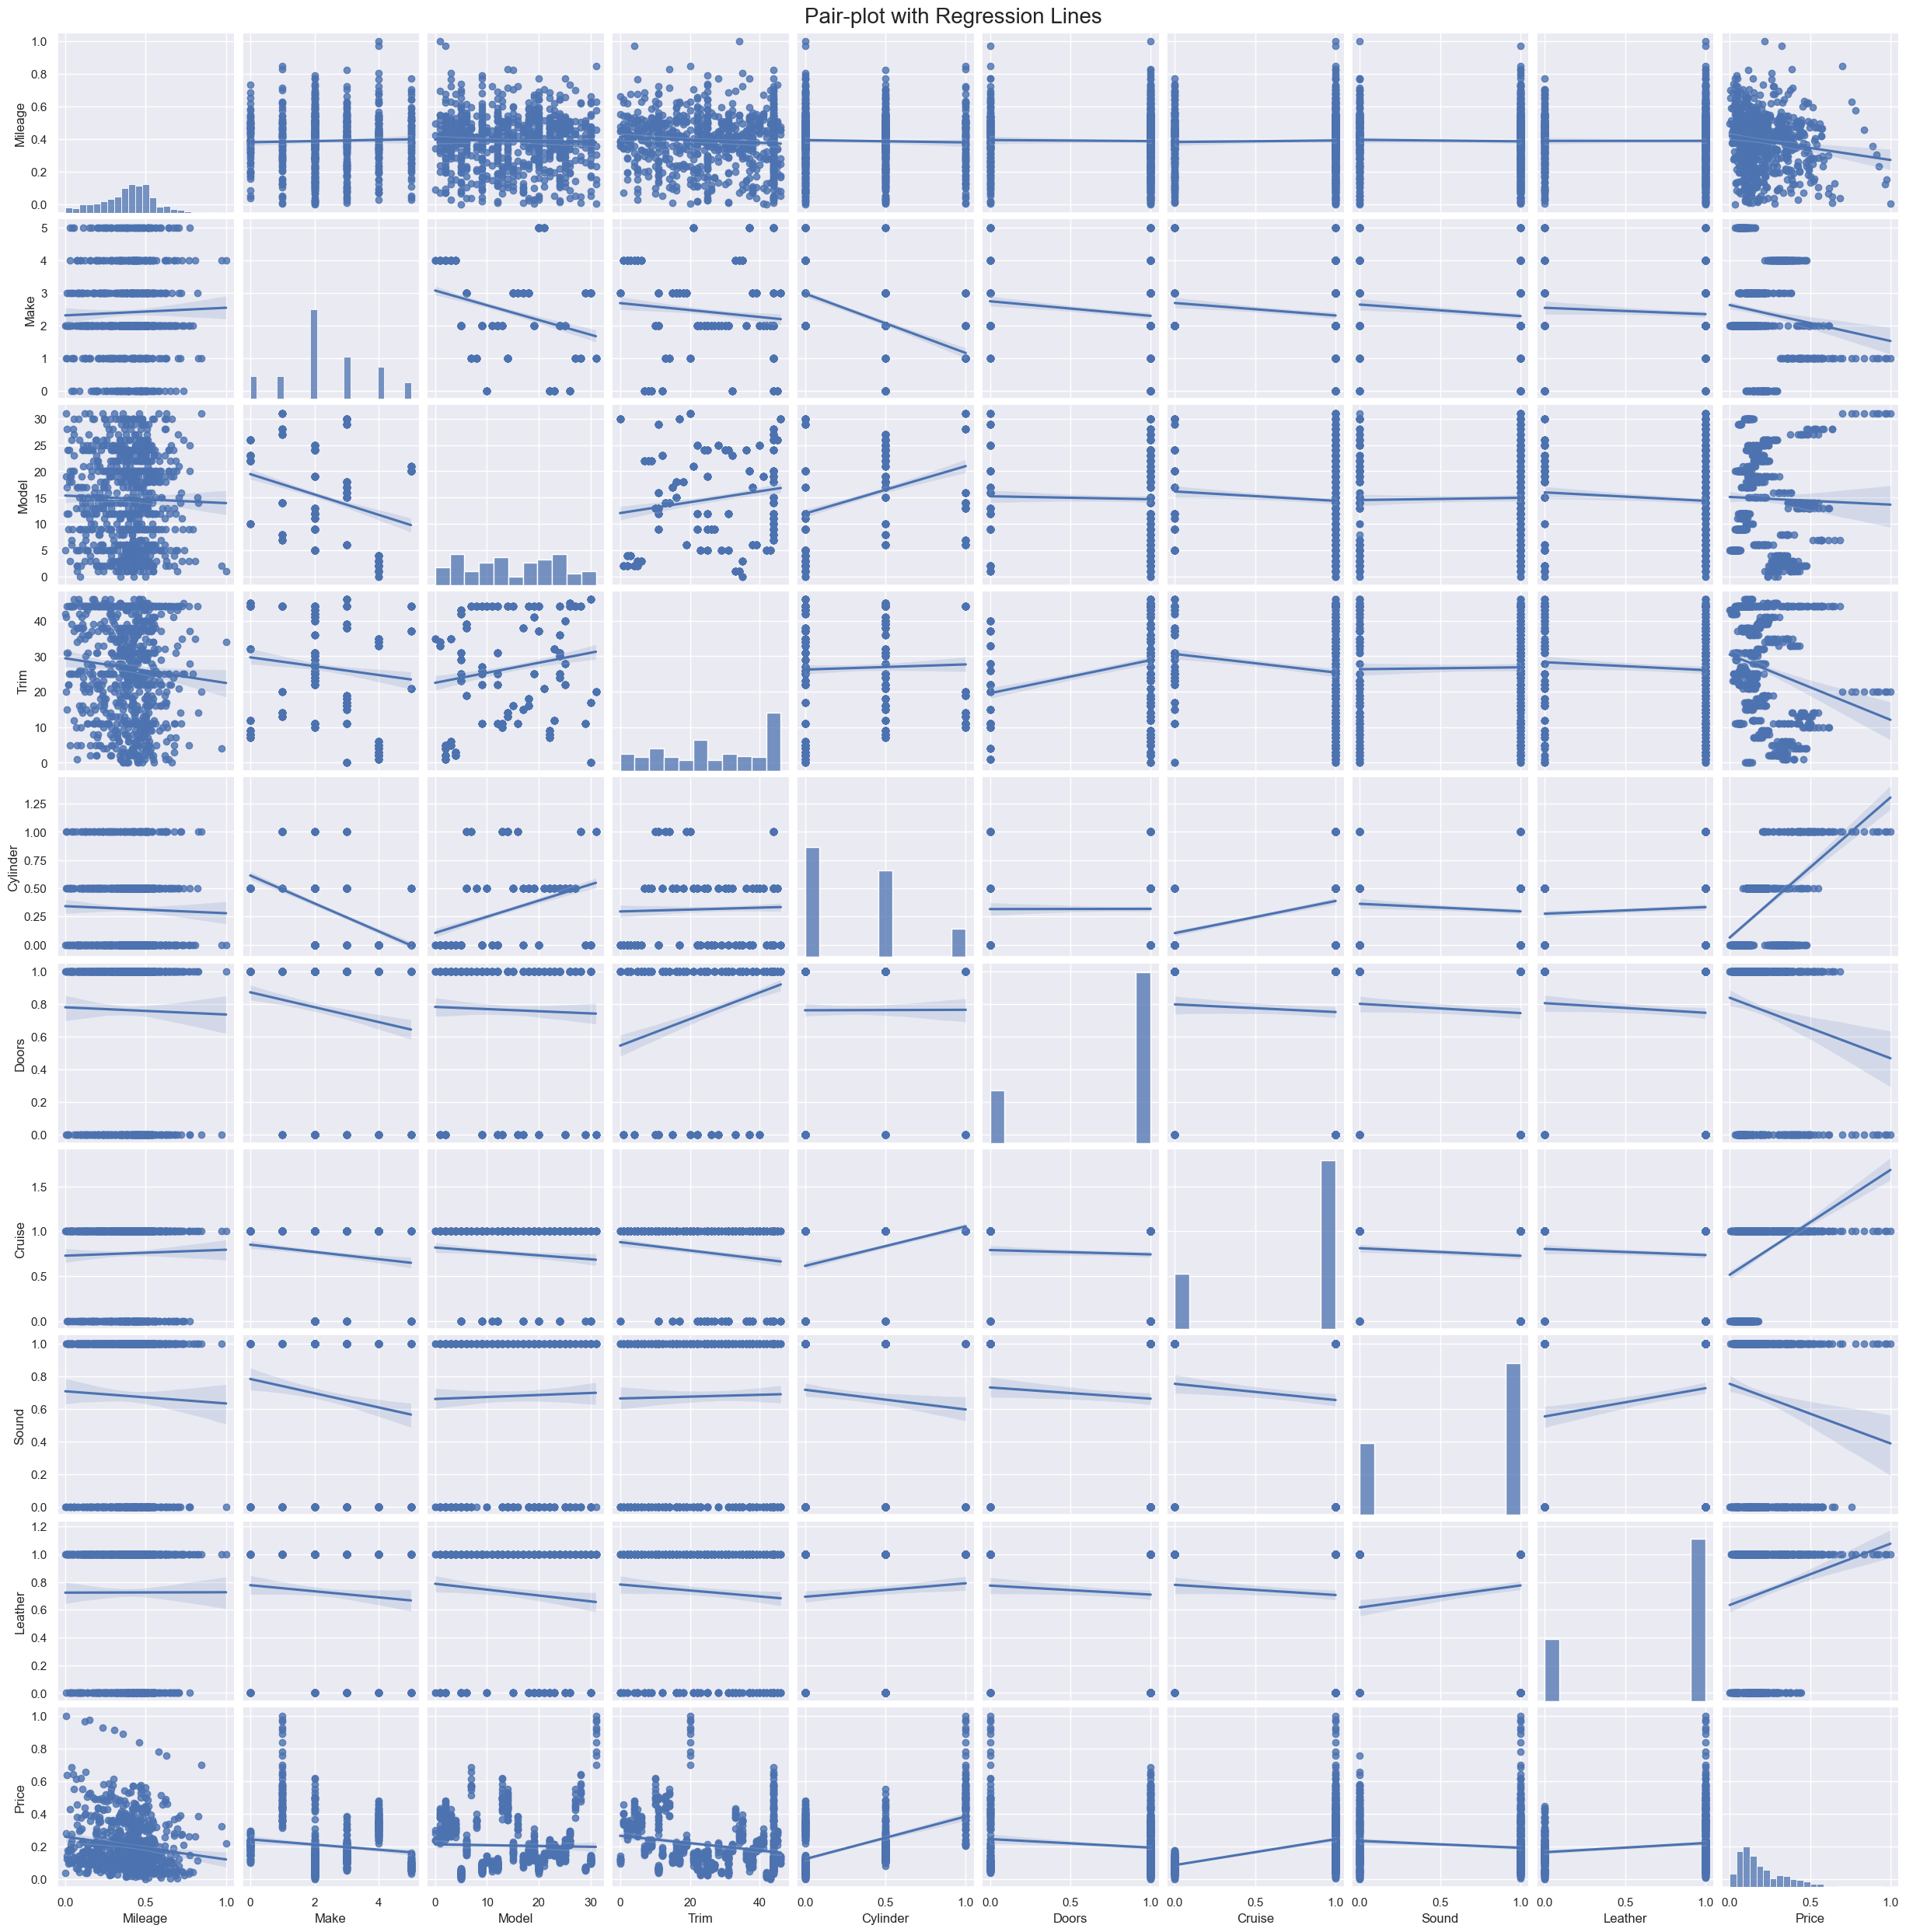

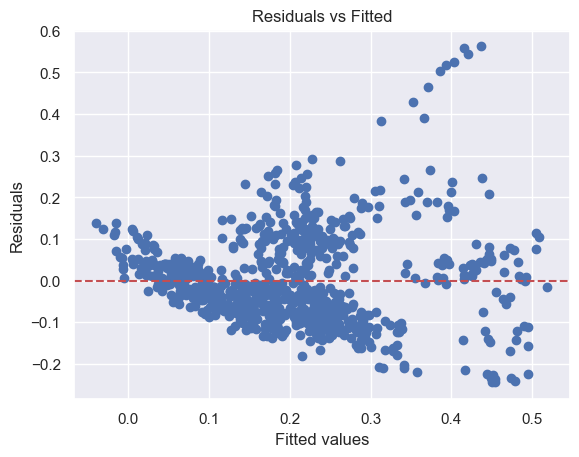

D:\PythonEnv\Matt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


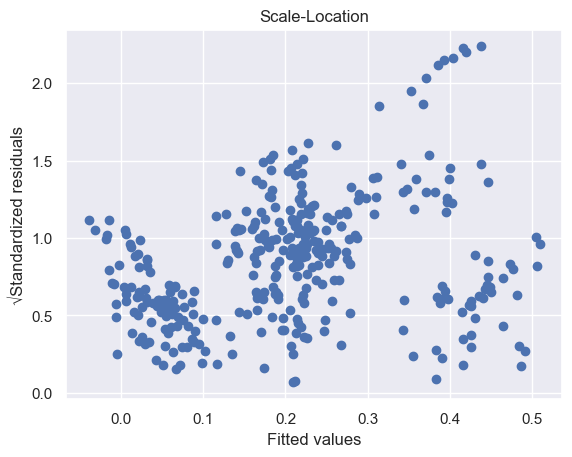

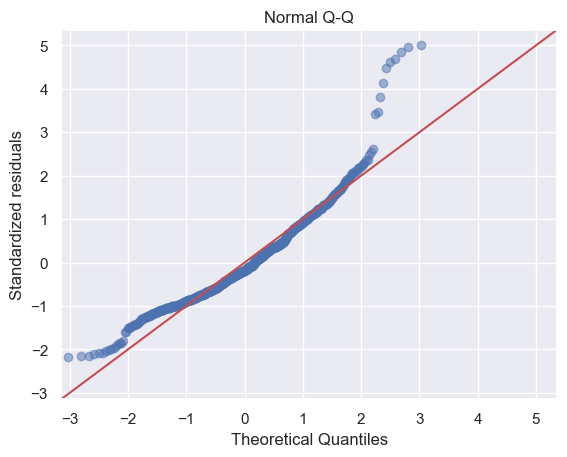

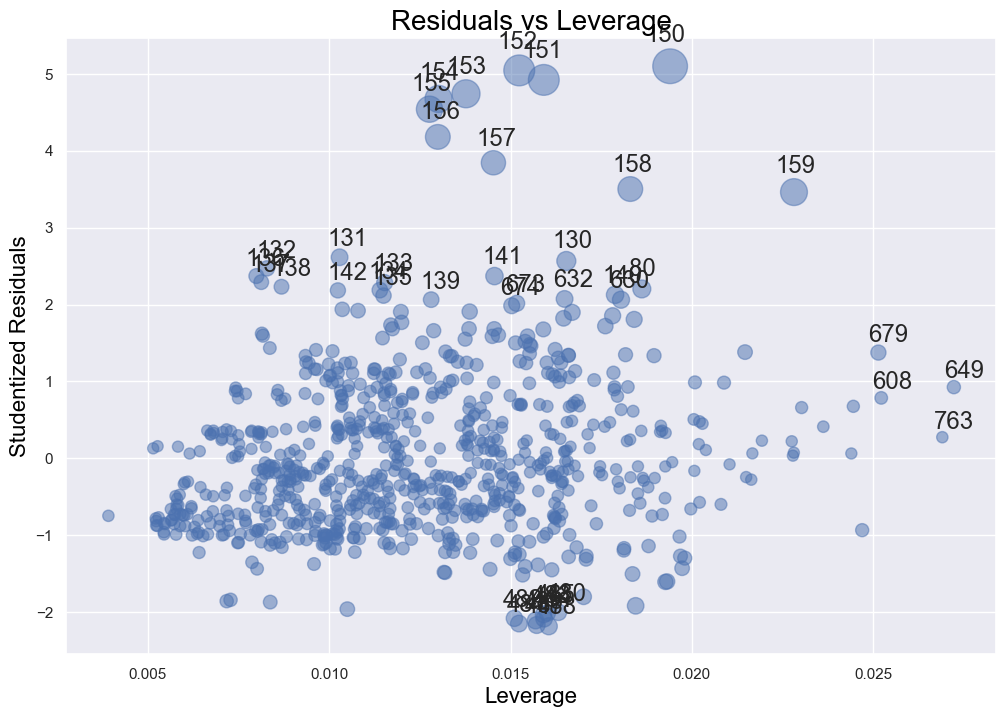

Breusch-Pagan test: 
LM statistic: 123.6476110886996      LM-Test p-value: 2.3907923310440827e-22 
F-statistic: 16.033554376387045       F-Test p-value: 2.6479000981633778e-24


,Variable,VIF,Tolerance
0,Mileage,5.684898,0.175905
1,Make,4.023498,0.248540
2,Model,4.343273,0.230241
3,Trim,4.720745,0.211831
4,Cylinder,3.097732,0.322817
5,Doors,4.166586,0.240005
6,Cruise,4.307424,0.232157
7,Sound,3.055368,0.327293
8,Leather,3.486773,0.286798


In [16]:
new_data = data[selected_features + [explore_column]]
enhanced_research = LinearRegressionResearch(new_data, column=explore_column)
enhanced_research.info()
enhanced_research.draw_plots()
enhanced_research.run_tests()

### Попытаемся улучшить уже улучшенную модель при помощи (Box-Cox)

                                   Price_t                                    
Dep. Variable:                Price_t   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     113.5
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          3.76e-136
Time:                        17:24:26   Log-Likelihood:                 1567.0
No. Observations:                 804   AIC:                            -3114.
Df Residuals:                     794   BIC:                            -3067.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0883      0.008     11.376      0.0

,df,sum_sq,mean_sq,F,PR(>F)
Mileage,1.0,0.046305,0.046305,38.508069,8.774732e-10
Make,1.0,0.017574,0.017574,14.615104,1.421739e-04
Model,1.0,0.007874,0.007874,6.548277,1.068289e-02
Trim,1.0,0.153380,0.153380,127.553824,1.555943e-27
Cylinder,1.0,0.847156,0.847156,704.512348,1.278663e-111
Doors,1.0,0.000342,0.000342,0.284321,5.940324e-01
Cruise,1.0,0.137070,0.137070,113.989834,5.879869e-25
Sound,1.0,0.003450,0.003450,2.868825,9.070298e-02
Leather,1.0,0.015162,0.015162,12.609305,4.064371e-04
Residual,794.0,0.954763,0.001202,NaN,NaN


,dfb_Intercept,dfb_Mileage,dfb_Make,dfb_Model,dfb_Trim,dfb_Cylinder,dfb_Doors,dfb_Cruise,dfb_Sound,dfb_Leather,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.022905,0.035310,0.044475,0.028232,-0.030654,0.005675,0.000822,-0.014630,-0.009473,-0.012417,0.000677,-0.762042,0.011517,-0.082255,-0.761840,-0.082233
1,-0.021775,0.016285,0.023781,0.019372,-0.013756,-0.002022,0.002058,-0.002829,-0.010161,0.025768,0.000233,-0.388081,0.015253,-0.048298,-0.387873,-0.048272
2,-0.029270,0.014488,0.036600,0.029827,-0.021880,-0.003422,0.003206,-0.004104,-0.015889,0.039679,0.000510,-0.596964,0.014098,-0.071385,-0.596722,-0.071356
3,-0.044932,0.008220,0.049840,0.030878,-0.025729,0.004623,0.008116,-0.002862,0.034273,0.034932,0.000677,-0.652933,0.015624,-0.082259,-0.652697,-0.082229
4,-0.029566,-0.001805,0.061893,0.029064,-0.038343,0.016139,0.006968,-0.013358,0.055303,-0.024512,0.000969,-0.841961,0.013482,-0.098429,-0.841807,-0.098411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.045766,0.032498,-0.158025,-0.062940,0.039370,-0.070610,-0.064527,-0.018950,0.041452,0.079051,0.005168,-1.796628,0.015757,-0.227323,-1.799157,-0.227643
800,0.090348,0.005793,-0.166788,-0.052226,0.037009,-0.085808,-0.069523,-0.020166,-0.092200,0.092735,0.004847,-1.620057,0.018132,-0.220153,-1.621719,-0.220379
801,0.098789,-0.004229,-0.174748,-0.054690,0.038070,-0.090227,-0.072815,-0.020893,-0.096879,0.097238,0.005319,-1.697450,0.018125,-0.230628,-1.699467,-0.230902
802,0.115587,-0.045185,-0.175428,-0.054787,0.035414,-0.091865,-0.072992,-0.020036,-0.098366,0.097926,0.005571,-1.704789,0.018807,-0.236022,-1.706842,-0.236306


,student_resid,unadj_p,bonferroni(p)
0,-0.761840,0.446382,1.0
1,-0.387873,0.698214,1.0
2,-0.596722,0.550864,1.0
3,-0.652697,0.514141,1.0
4,-0.841807,0.400150,1.0
...,...,...,...
799,-1.799157,0.072374,1.0
800,-1.621719,0.105261,1.0
801,-1.699467,0.089623,1.0
802,-1.706842,0.088243,1.0


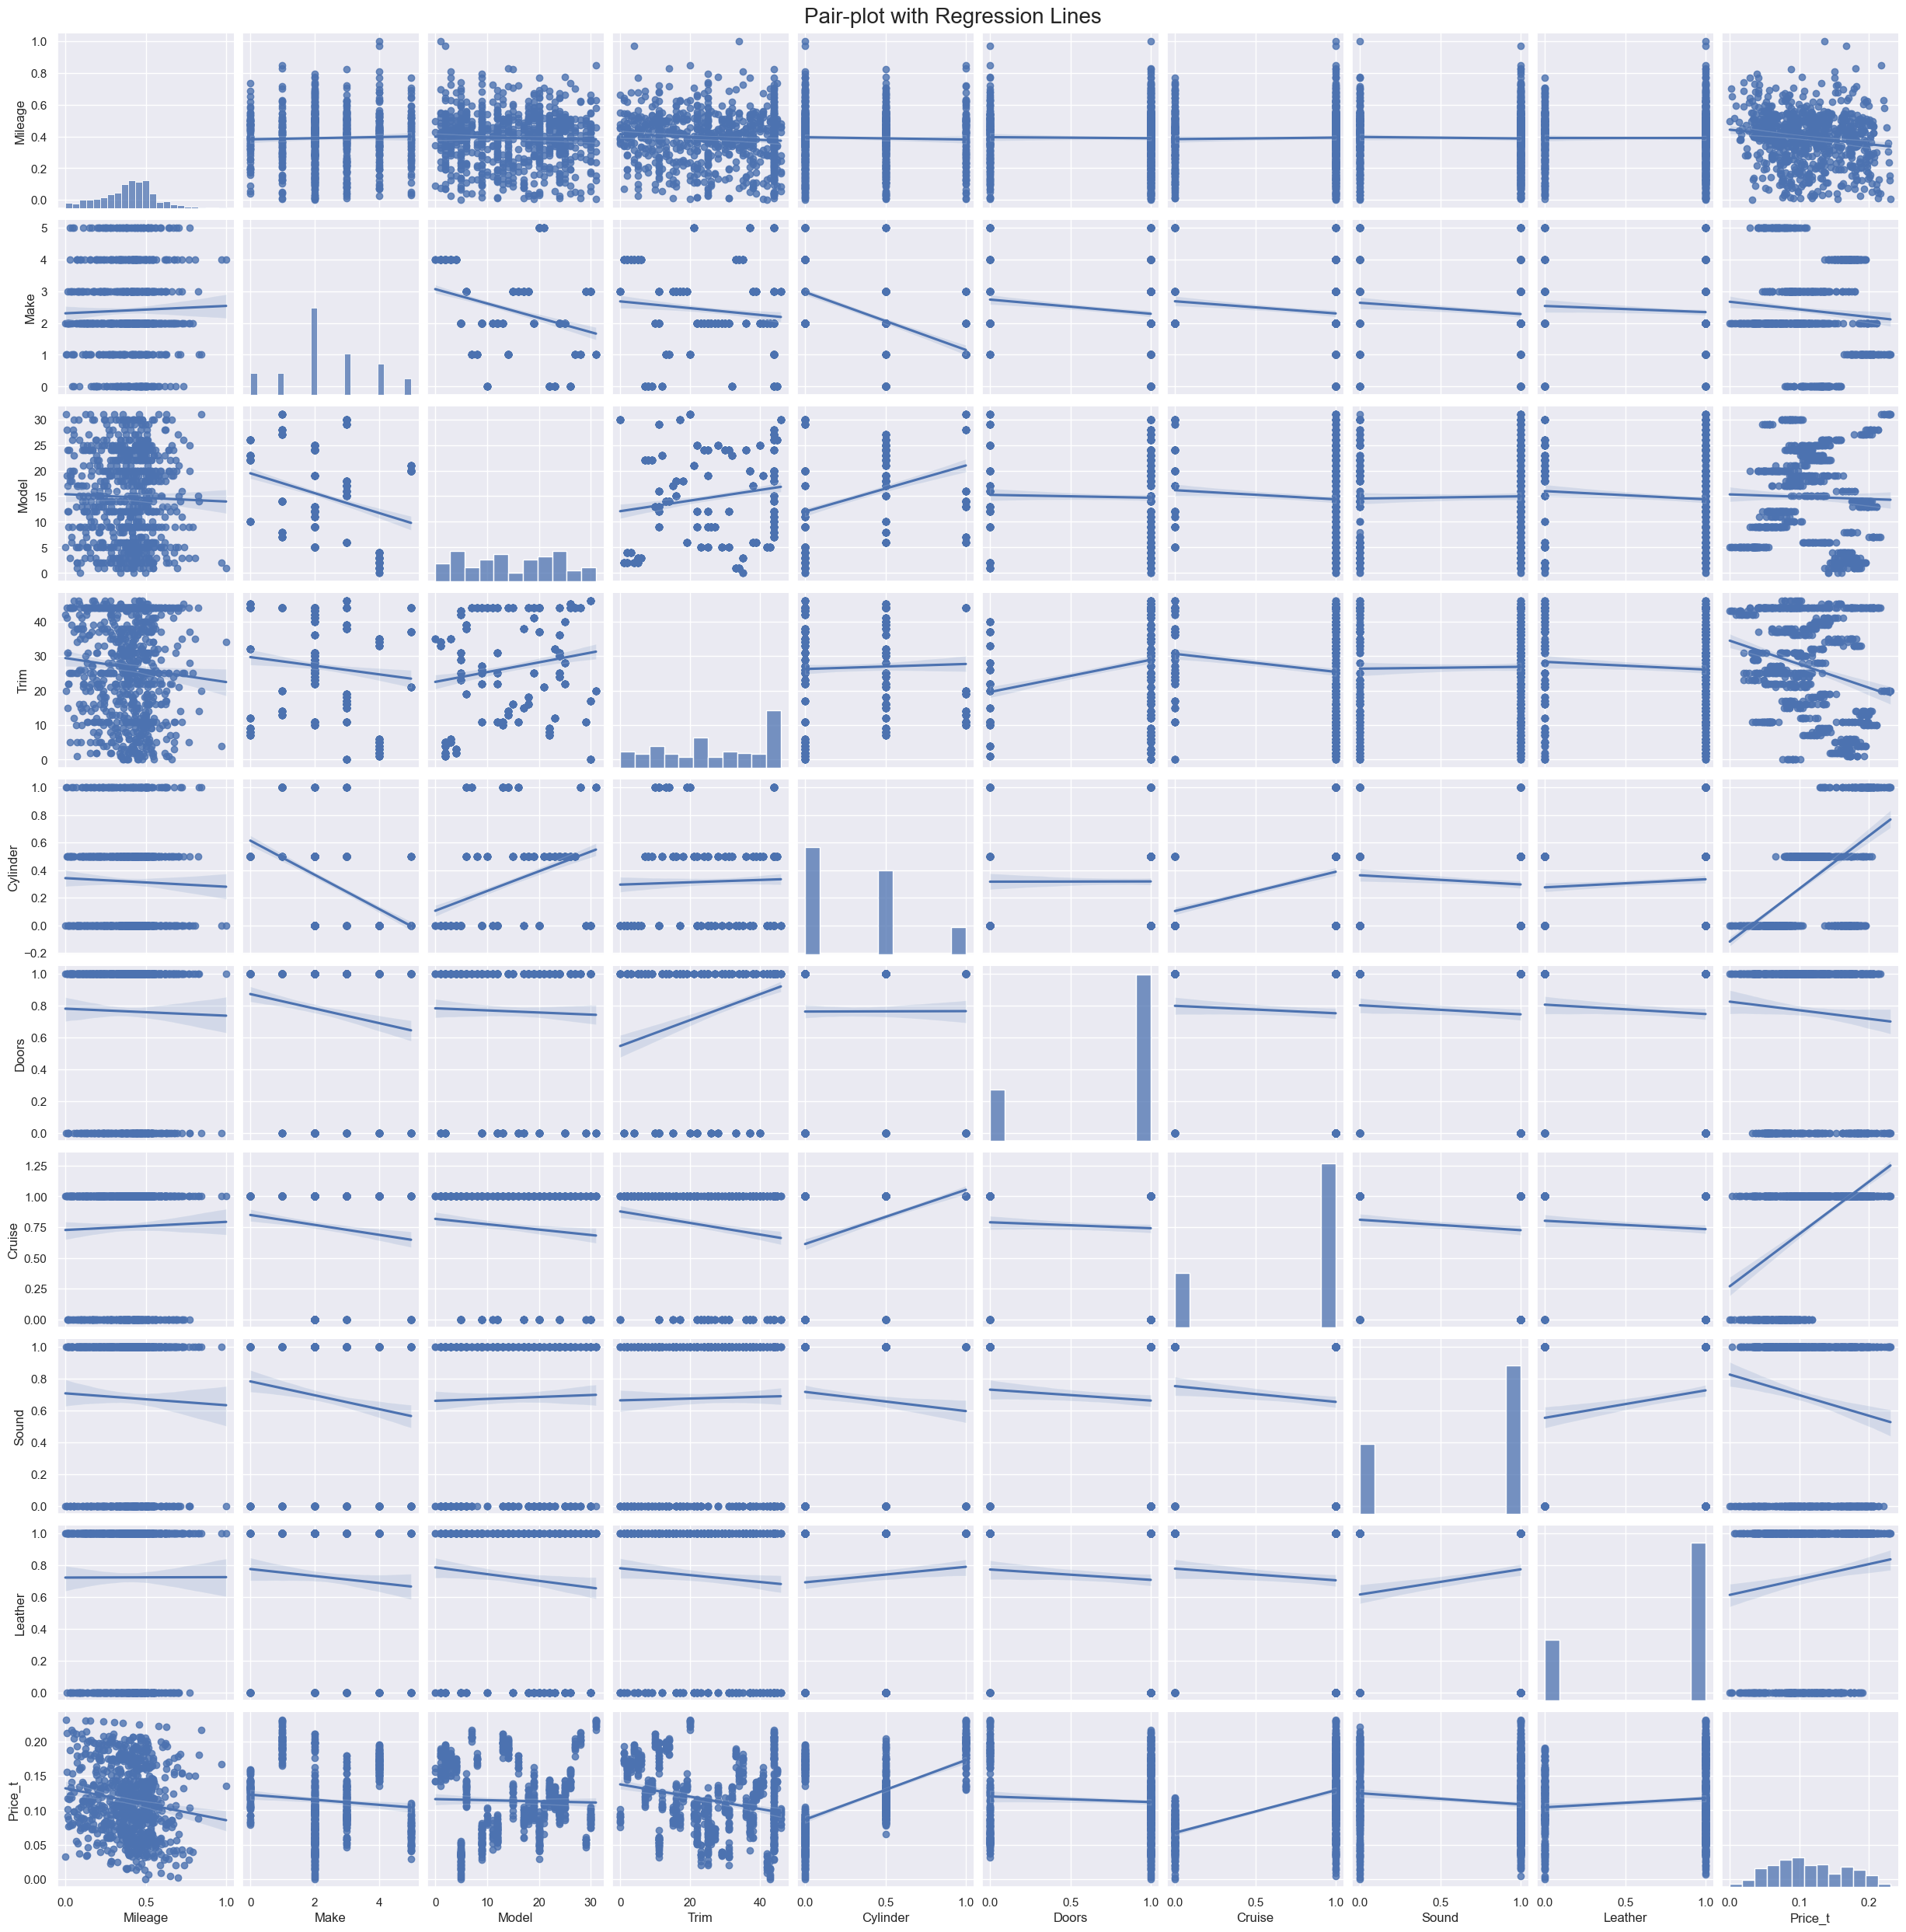

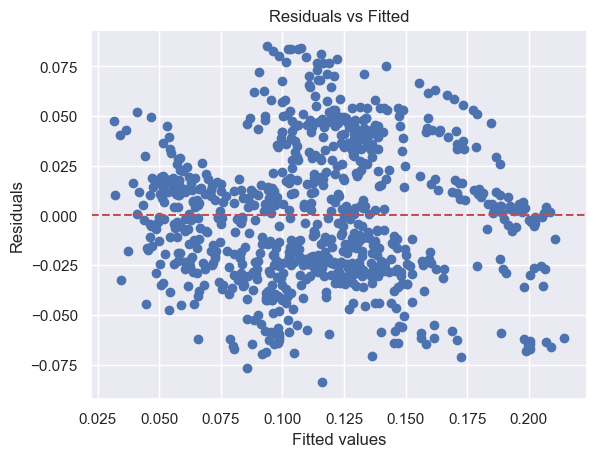

D:\PythonEnv\Matt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


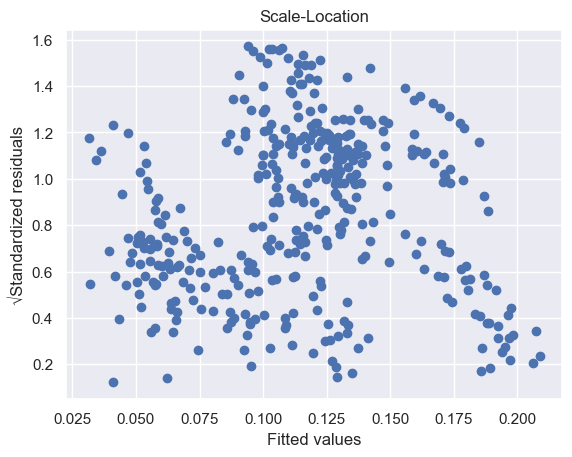

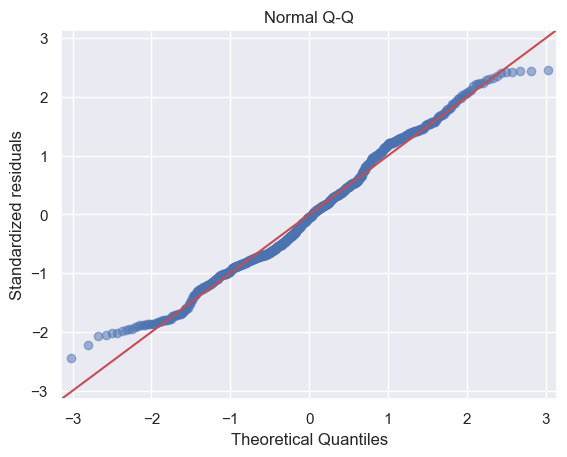

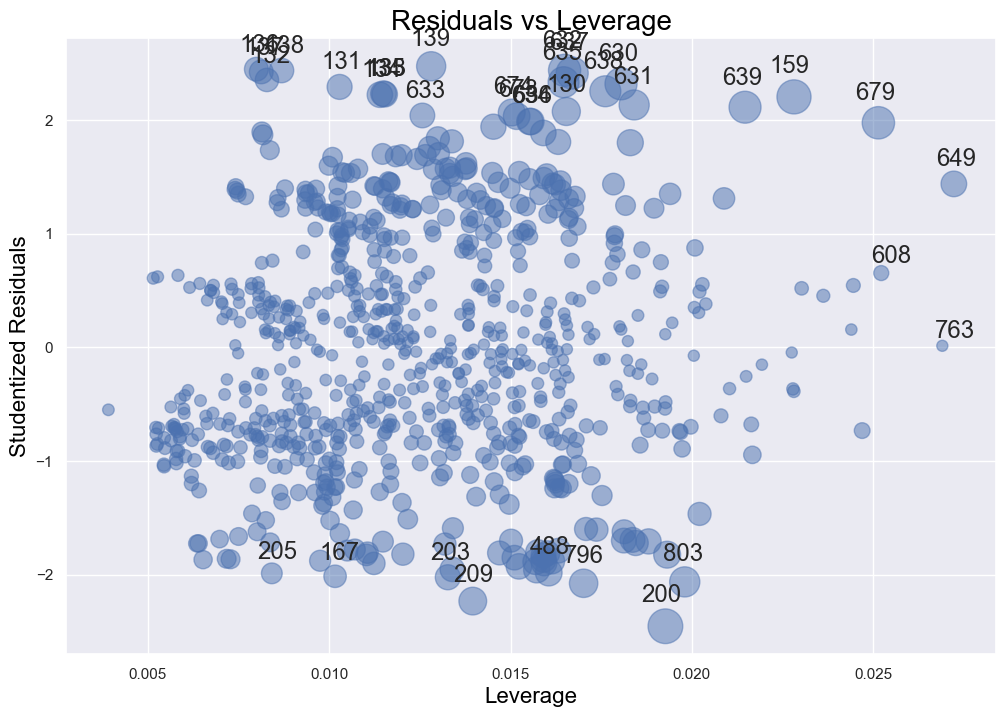

Breusch-Pagan test: 
LM statistic: 148.13408394133802      LM-Test p-value: 2.147149382709389e-27 
F-statistic: 19.925899108605527       F-Test p-value: 2.3636355366990558e-30


,Variable,VIF,Tolerance
0,Mileage,5.684898,0.175905
1,Make,4.023498,0.248540
2,Model,4.343273,0.230241
3,Trim,4.720745,0.211831
4,Cylinder,3.097732,0.322817
5,Doors,4.166586,0.240005
6,Cruise,4.307424,0.232157
7,Sound,3.055368,0.327293
8,Leather,3.486773,0.286798


In [17]:
# Применяем преобразование Бокса-Кокса к зависимой переменной
y_transformed, lambda_value = boxcox(data[explore_column] + 1)  # + 1 чтобы не было 0-значений
new_explore_column = explore_column + '_t'
data[new_explore_column] = y_transformed

new_data = data[selected_features + [new_explore_column]]
# Проводим анализ заново
enhanced_research = LinearRegressionResearch(new_data, column=new_explore_column)
enhanced_research.info()
enhanced_research.draw_plots()
enhanced_research.run_tests()